In [1]:
import pennylane as qml
from jax import numpy as np
from matplotlib import pyplot as plt
import jax

jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

# set the random seed
key = jax.random.PRNGKey(42)


# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")

    qml.RX(params[3], wires=0)
    qml.RY(params[4], wires=1)
    qml.RZ(params[5], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

In [2]:
params = jax.random.normal(key, [6])

print("Parameters:", params)
print("Expection value:", circuit(params))

Parameters: [ 0.37087464 -1.1752595  -0.51433962  1.94757307 -1.29836488 -0.61030051]
Expection value: 0.9531866702850619


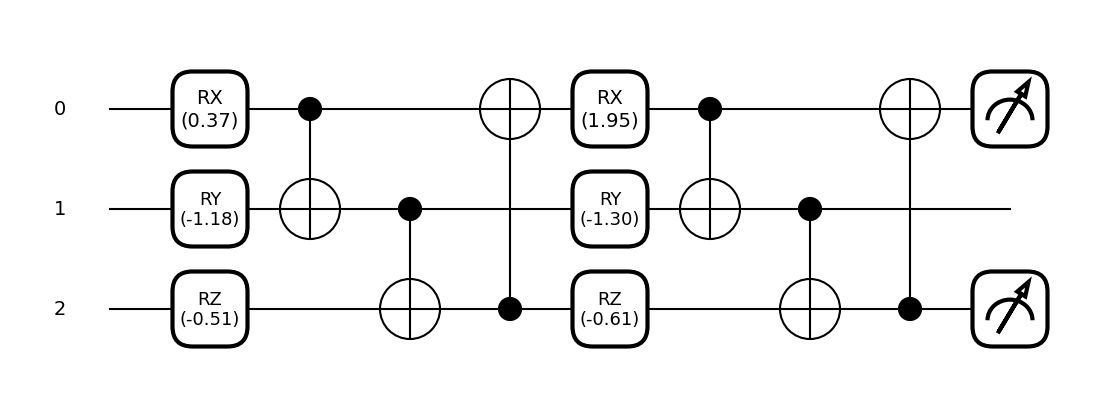

In [4]:
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [5]:
def parameter_shift_term(qnode, params, i):
    shifted = params.copy()
    shifted = shifted.at[i].add(np.pi/2)
    forward = qnode(shifted)
    
    shifted = shifted.at[i].add(-np.pi/2)
    backward = qnode(shifted)
    
    return 0.5 * (forward - backward)
# gradient with respect to the first parameter
print(parameter_shift_term(circuit, params, 0))

-0.48650098251568497


In [26]:
def parameter_shift(qnode, params):
    gradients = np.zeros([len(params)])
    for i in range(len(params)):
        gradients = gradients.at[i].set(parameter_shift_term(qnode, params, i))

    return gradients

print(parameter_shift(circuit, params))

[-0.40247965 -0.33596174 -0.5065301  -0.43327457 -0.41376123 -0.44814016
 -0.35695158 -0.47458753 -0.36015647 -0.62640902 -0.45844211 -0.37188157
 -0.469658   -0.42046558 -0.48452843]


In [28]:
grad_function = jax.grad(circuit)
print(grad_function(params)[0])

[[-2.28753106e-16  9.53230259e-03 -1.99267365e-04]
 [-2.32669786e-16  5.81909542e-02  1.99219276e-03]
 [-2.38524478e-16 -1.31256784e-01  2.71675552e-03]
 [-2.52835947e-16 -1.14599760e-01  5.43812451e-03]]


In [9]:
print(qml.gradients.param_shift(circuit)(params))

(Array(-0.01981529, dtype=float64), Array(-0.04948435, dtype=float64), Array(1.16219626e-16, dtype=float64), Array(-0.0307452, dtype=float64), Array(-0.26629899, dtype=float64), Array(-5.03138276e-17, dtype=float64))


In [10]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

# initialize circuit parameters
param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=15)
params = jax.random.normal(key, param_shape) * 0.1

print(params.size)
print(circuit(params))

180
0.9127089083181129


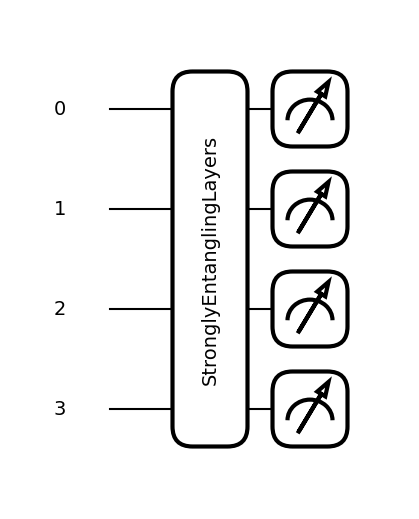

In [11]:
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [12]:
import timeit

reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num

print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.15451083630032372 sec per loop


In [13]:
# create the gradient function
grad_fn = jax.grad(circuit)

times = timeit.repeat("grad_fn(params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num

print(f"Gradient computation (best of {reps}): {backward_time} sec per loop")

Gradient computation (best of 3): 7.399976269400213 sec per loop


In [14]:
print(2 * forward_time * params.size)

55.62390106811654


In [15]:
dev = qml.device("default.qubit", wires=4)

In [16]:
@qml.qnode(dev, diff_method="backprop")
def circuit(params):
    qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

# initialize circuit parameters
param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=15)
params = jax.random.normal(key, param_shape) * 0.1

print(circuit(params))

0.9127089083181127


In [17]:
import timeit

reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num
print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.3001726543996483 sec per loop


In [18]:
times = timeit.repeat("jax.grad(circuit)(params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num
print(f"Backward pass (best of {reps}): {backward_time} sec per loop")

Backward pass (best of 3): 2.414135700798943 sec per loop
